In [ ]:
### Please first dowbnload the dataset

In [1]:
import glob
import sys
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import etl
import ml
import plot_util
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'Python version: {sys.version}')
print(f'Numpy version: {np.__version__}')
print(f'Scipy version: {sp.__version__}')
print(f'sklearn version: {sklearn.__version__}')

Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]
Numpy version: 1.26.4
Scipy version: 1.13.1
sklearn version: 1.4.2


# Algorithm implementation and evaluation

Signal shape: (10000,)
First 10 signal samples: [1598.99864339 1589.99815607 1594.99795557 1598.99864339 1604.99813868
 1604.99813868 1607.99901853 1614.00276824 1616.00071018 1620.00346081]
Number of QRS annotations: 13
Annotation samples: [ 575 1299 2023 2746 3467 4189 4920 5648 6371 7098]
Length of ECG signal: 10000


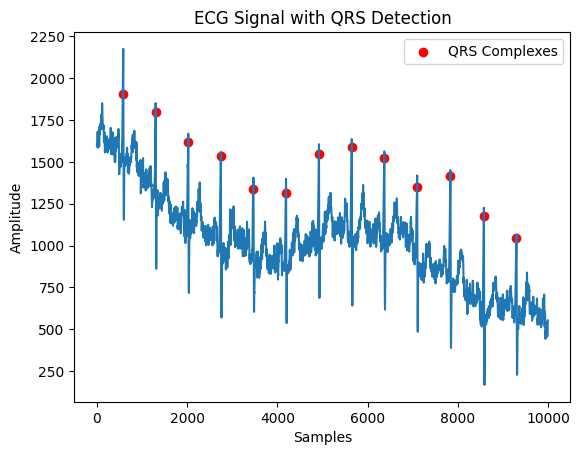

In [39]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG signal and check its structure
record = wfdb.rdrecord('100001_ECG')  
signals = record.p_signal.flatten()  # Flatten to 1D array
print(f"Signal shape: {signals.shape}")  # Check the dimensions of the signal
print(f"First 10 signal samples: {signals[:10]}")  # Print the first 10 samples

# Load the QRS annotations
annotations = wfdb.rdann('100001', 'qrs')

# Display the QRS annotation samples
print(f"Number of QRS annotations: {len(annotations.sample)}")
print(f"Annotation samples: {annotations.sample[:10]}")  # First 10 annotation indices

# Check if annotations are valid for the signal
print(f"Length of ECG signal: {len(signals)}")
if len(signals) > 1:
    # Filter valid QRS annotation indices that are within the signal bounds
    valid_indices = annotations.sample[annotations.sample < len(signals)]  # Ensure the indices are within bounds
    valid_signal_values = signals[valid_indices]  # Corresponding signal values at valid indices

    # Plot the ECG signal
    plt.plot(signals)

    # Mark the QRS complex locations (only for valid indices)
    plt.scatter(valid_indices, valid_signal_values, color='red', label='QRS Complexes')

    plt.title('ECG Signal with QRS Detection')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
else:
    print("ECG signal is not loaded correctly. Check your signal file and path.")


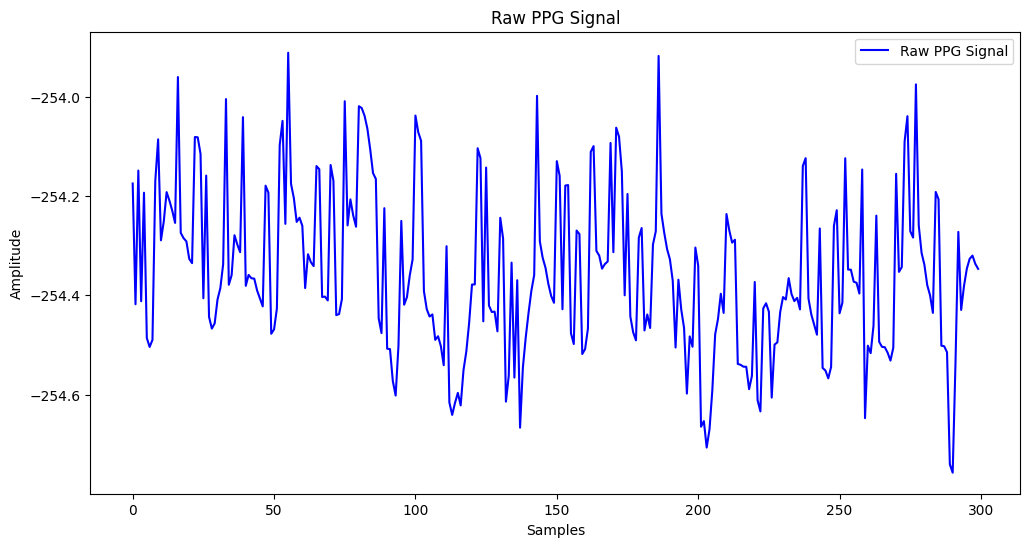

In [49]:
import wfdb
import matplotlib.pyplot as plt

# Load the ECG signal and flatten it to 1D array
ecg_record = wfdb.rdrecord('100001_ECG')  
ecg_signals = ecg_record.p_signal.flatten()  # Flatten to 1D array

# Load the PPG signal (replace '100001_PPG' with your actual PPG record name)
ppg_record = wfdb.rdrecord('100001_PPG')  
ppg_signals = ppg_record.p_signal.flatten()  # Flatten to 1D array

# Ensure both signals have the same length (they should ideally)
min_length = min(len(ecg_signals), len(ppg_signals))  # To match the signal lengths

# Truncate both signals to the same length (if necessary)
ecg_signals = ecg_signals[:min_length]
ppg_signals = ppg_signals[:min_length]

import matplotlib.pyplot as plt

# Plot the raw PPG signal (without any shifting)
plt.figure(figsize=(12, 6))
plt.plot(ppg_signals, label='Raw PPG Signal', color='blue')
#plt.plot(ecg_signals, label='Raw PPG Signal', color='green')
plt.title('Raw PPG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



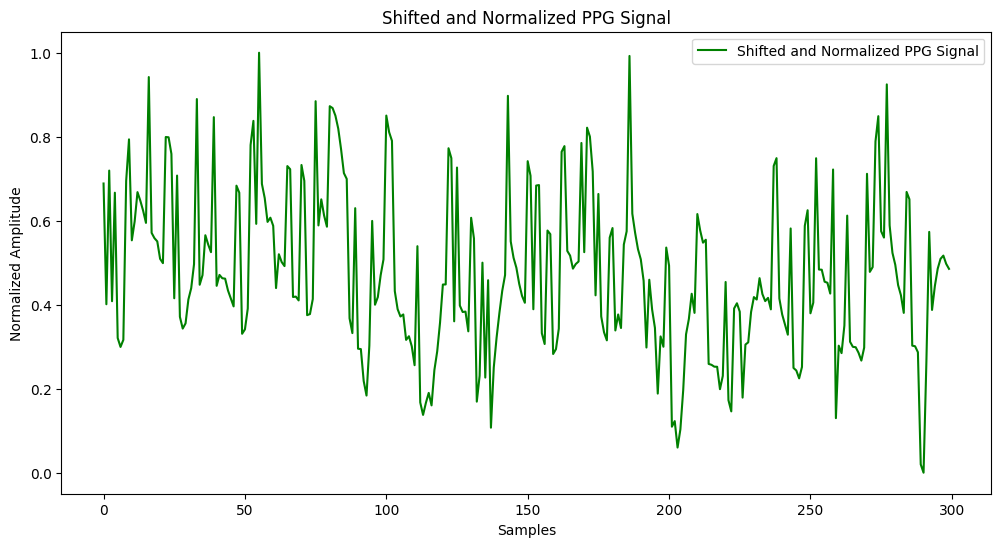

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Shift the signal to positive values by adding the absolute value of the minimum
shifted_ppg = ppg_signals + abs(np.min(ppg_signals))

# Normalize the shifted signal to range between 0 and 1
normalized_ppg = shifted_ppg / np.max(shifted_ppg)

# Plot the shifted and normalized PPG signal
plt.figure(figsize=(12, 6))
plt.plot(normalized_ppg, label='Shifted and Normalized PPG Signal', color='green')
plt.title('Shifted and Normalized PPG Signal')
plt.xlabel('Samples')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.show()


Raw ECG Min: 167.9999712881912
Raw ECG Max: 2174.0024681201153


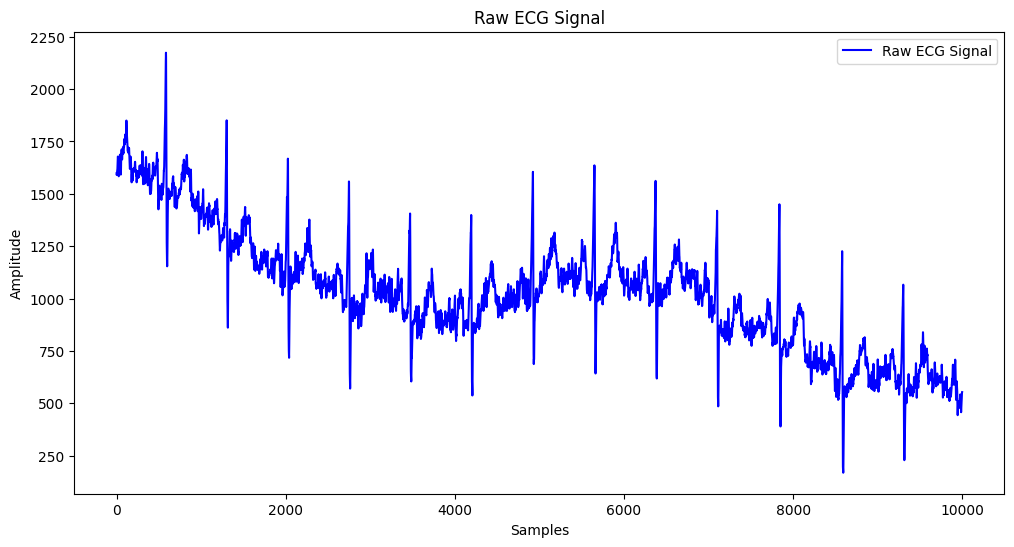

In [71]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Load the ECG signal and flatten it to 1D array
ecg_record = wfdb.rdrecord('100001_ECG')  
ecg_signals = ecg_record.p_signal.flatten()  # Flatten to 1D array

# Check the raw range of the ECG signal
ecg_min = np.min(ecg_signals)
ecg_max = np.max(ecg_signals)

print("Raw ECG Min:", ecg_min)
print("Raw ECG Max:", ecg_max)

# Plot the raw ECG signal to visually inspect its amplitude
plt.figure(figsize=(12, 6))
plt.plot(ecg_signals, label='Raw ECG Signal', color='blue')
plt.title('Raw ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


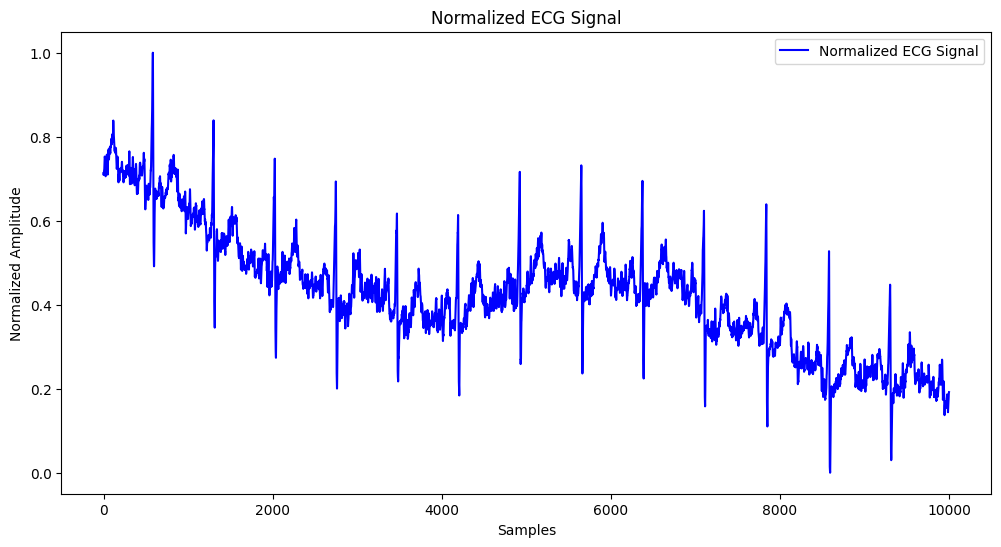

In [63]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Load the ECG signal and flatten it to 1D array
ecg_record = wfdb.rdrecord('100001_ECG')  
ecg_signals = ecg_record.p_signal.flatten()  # Flatten to 1D array

# Check the raw range of the ECG signal
ecg_min = np.min(ecg_signals)
ecg_max = np.max(ecg_signals)

# Normalize the ECG signal to the range [0, 1]
normalized_ecg = (ecg_signals - ecg_min) / (ecg_max - ecg_min)

# Plot the normalized ECG signal
plt.figure(figsize=(12, 6))
plt.plot(normalized_ecg, label='Normalized ECG Signal', color='blue')
plt.title('Normalized ECG Signal')
plt.xlabel('Samples')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.show()


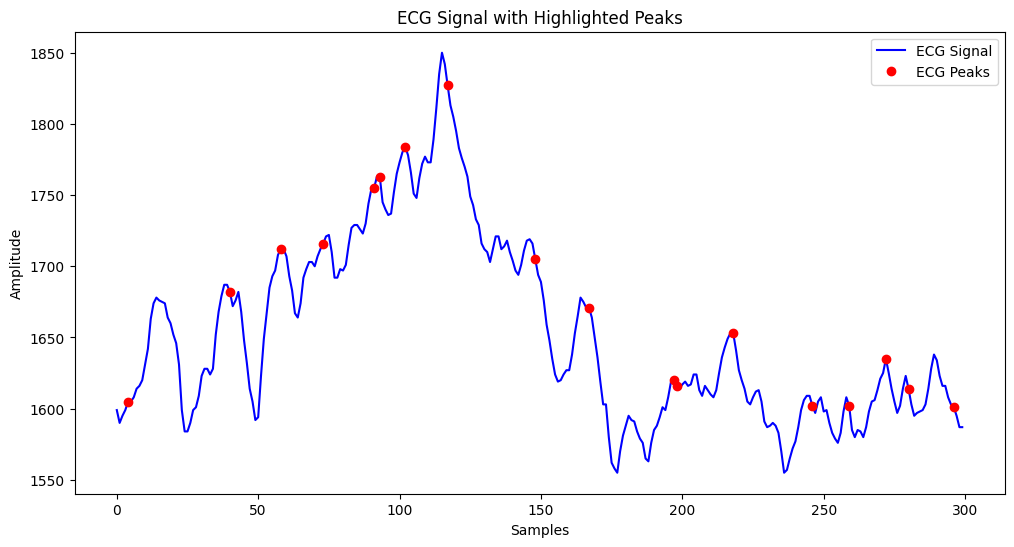

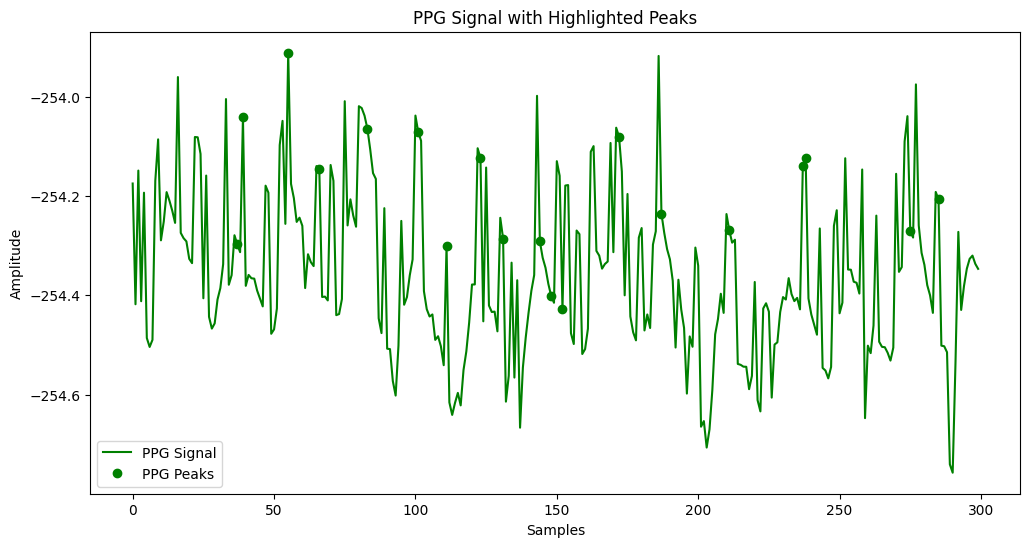

Number of ECG peaks: 18
Number of PPG peaks: 19


In [97]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Load the ECG signal and flatten it to 1D array
ecg_record = wfdb.rdrecord('100001_ECG')  
ecg_signals = ecg_record.p_signal.flatten()  # Flatten to 1D array

# Load the PPG signal and flatten it to 1D array
ppg_record = wfdb.rdrecord('100001_PPG')  
ppg_signals = ppg_record.p_signal.flatten()  # Flatten to 1D array

# Ensure both signals have the same length (truncate if necessary)
min_length = min(len(ecg_signals), len(ppg_signals))
ecg_signals = ecg_signals[:min_length]
ppg_signals = ppg_signals[:min_length]

# Check the raw range of the ECG signal
ecg_min = np.min(ecg_signals)
ecg_max = np.max(ecg_signals)

# Use find_peaks_cwt to find peaks in the raw ECG signal
ecg_peakind = signal.find_peaks_cwt(ecg_signals, np.arange(1, 10))

# Use find_peaks_cwt to find peaks in the raw PPG signal
ppg_peakind = signal.find_peaks_cwt(ppg_signals, np.arange(1, 10))

# Plot the ECG signal with highlighted peaks
plt.figure(figsize=(12, 6))
plt.plot(ecg_signals, label='ECG Signal', color='blue')
plt.plot(ecg_peakind, ecg_signals[ecg_peakind], 'ro', label='ECG Peaks')  # Red dots for peaks
plt.title('ECG Signal with Highlighted Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the PPG signal with highlighted peaks
plt.figure(figsize=(12, 6))
plt.plot(ppg_signals, label='PPG Signal', color='green')
plt.plot(ppg_peakind, ppg_signals[ppg_peakind], 'go', label='PPG Peaks')  # Green dots for peaks
plt.title('PPG Signal with Highlighted Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

print(f"Number of ECG peaks: {len(ecg_peakind)}")
print(f"Number of PPG peaks: {len(ppg_peakind)}")



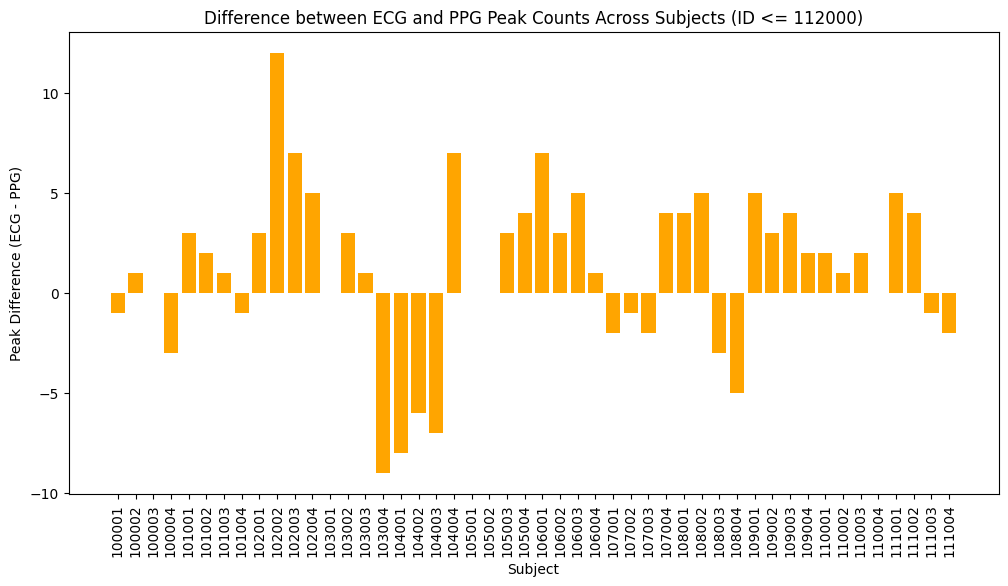

In [159]:
import matplotlib.pyplot as plt

# Sort the peak_counts list by the subject IDs in ascending order
sorted_peak_counts = sorted(peak_counts, key=lambda x: int(x['subject']))

# Filter subjects where subject ID is less than or equal to '112000'
filtered_peak_counts = [entry for entry in sorted_peak_counts if int(entry['subject']) <= 112000]

# Get the list of subjects, ECG peaks, and PPG peaks from the filtered list
subject_names = [entry['subject'] for entry in filtered_peak_counts]
ecg_peaks = [entry['ECG Peaks'] for entry in filtered_peak_counts]
ppg_peaks = [entry['PPG Peaks'] for entry in filtered_peak_counts]

# Calculate the difference between ECG and PPG peaks
peak_diff = np.array(ecg_peaks) - np.array(ppg_peaks)

# Plot the difference between ECG and PPG peaks
plt.figure(figsize=(12, 6))
plt.bar(subject_names, peak_diff, color='orange')
plt.title('Difference between ECG and PPG Peak Counts Across Subjects (ID <= 112000)')
plt.xlabel('Subject')
plt.ylabel('Peak Difference (ECG - PPG)')
plt.xticks(rotation=90)  # Rotate subject names for better visibility
plt.show()


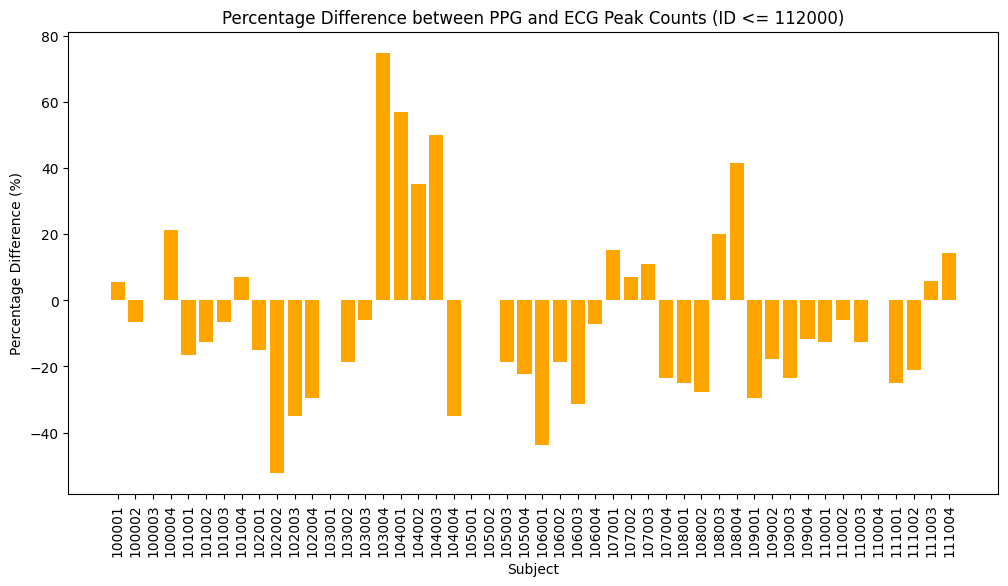

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the peak_counts list by the subject IDs in ascending order
sorted_peak_counts = sorted(peak_counts, key=lambda x: int(x['subject']))

# Filter subjects where subject ID is less than or equal to '112000'
filtered_peak_counts = [entry for entry in sorted_peak_counts if int(entry['subject']) <= 112000]

# Get the list of subjects, ECG peaks, and PPG peaks from the filtered list
subject_names = [entry['subject'] for entry in filtered_peak_counts]
ecg_peaks = [entry['ECG Peaks'] for entry in filtered_peak_counts]
ppg_peaks = [entry['PPG Peaks'] for entry in filtered_peak_counts]

# Calculate the percentage difference: (PPG - ECG) / ECG * 100
percentage_diff = np.array(ppg_peaks) - np.array(ecg_peaks)
percentage_diff = (percentage_diff / np.array(ecg_peaks)) * 100

# Plot the percentage difference between PPG and ECG peaks
plt.figure(figsize=(12, 6))
plt.bar(subject_names, percentage_diff, color='orange')
plt.title('Percentage Difference between PPG and ECG Peak Counts (ID <= 112000)')
plt.xlabel('Subject')
plt.ylabel('Percentage Difference (%)')
plt.xticks(rotation=90)  # Rotate subject names for better visibility
plt.show()


### Predicting peaks for a single signal based on find_peaks_cwt()

In [2]:
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def detect_peaks_in_signal(signal_data: np.ndarray) -> int:
    """
    Detect peaks in the given signal data using continuous wavelet transform.
    """
    peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
    return len(peak_indices)

def extract_signals_for_subject(subject_id: str, signal_type: str = "ECG") -> np.ndarray:
    """
    Extracts the signal data (ECG or PPG) for a given subject.
    """
    # Load the signal (ECG or PPG) for the given subject
    file_path = f"./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0/{subject_id}/{subject_id}_{signal_type}"
    record = wfdb.rdrecord(file_path)
    signal_data = record.p_signal.flatten()
    return signal_data

def split_signal_into_chunks(signal_data: np.ndarray, chunk_size: int = 300) -> list:
    """
    Splits the signal data into chunks of specified size.
    """
    return [signal_data[i:i + chunk_size] for i in range(0, len(signal_data), chunk_size) if len(signal_data[i:i + chunk_size]) == chunk_size]

# Train on subject 100001
subject_id = "100001"
chunk_size = 300

try:
    # Extract and process ECG signal for training
    print(f"Processing ECG for subject {subject_id}...")
    ecg_signal = extract_signals_for_subject(subject_id, signal_type="ECG")
    
    # Split the ECG signal into chunks
    ecg_chunks = split_signal_into_chunks(ecg_signal, chunk_size=chunk_size)
    
    # Detect peaks for each chunk
    X_train = []
    y_train = []
    for chunk in ecg_chunks:
        X_train.append(chunk)  # Add the chunk as a training sample
        y_train.append(detect_peaks_in_signal(chunk))  # Label is the peak count for the chunk
    
    # Convert to numpy arrays for model training
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    print(f"Model trained on subject {subject_id} ECG.")

    # Test on the PPG signal of the same subject
    print(f"Processing PPG for subject {subject_id}...")
    ppg_signal = extract_signals_for_subject(subject_id, signal_type="PPG")
    
    # Split the PPG signal into chunks
    ppg_chunks = split_signal_into_chunks(ppg_signal, chunk_size=chunk_size)

    # Predict the number of peaks for each PPG chunk
    predictions = []
    actual_counts = []
    for chunk in ppg_chunks:
        predicted_peaks = model.predict([chunk])[0]
        actual_peaks = detect_peaks_in_signal(chunk)
        predictions.append(predicted_peaks)
        actual_counts.append(actual_peaks)

    # Output the results
    for i, (pred, actual) in enumerate(zip(predictions, actual_counts)):
        print(f"PPG Chunk {i + 1}: Predicted Peaks = {pred:.2f}, Actual Peaks = {actual}")

except Exception as e:
    print(f"Failed to process subject {subject_id}: {e}")


Processing ECG for subject 100001...
Model trained on subject 100001 ECG.
Processing PPG for subject 100001...
PPG Chunk 1: Predicted Peaks = 16.86, Actual Peaks = 19


### RandomForestRegressor model

In [62]:
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


class SignalProcessor:
    def __init__(self, database_path: str, chunk_size: int = 300):
        self.database_path = database_path
        self.chunk_size = chunk_size

    def detect_peaks_in_signal(self, signal_data: np.ndarray) -> int:
        """
        Detect peaks in the given signal data using continuous wavelet transform.
        """
        peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
        return len(peak_indices)

    def extract_signals_for_subject(self, subject_id: str, signal_type: str = "ECG") -> np.ndarray:
        """
        Extracts the signal data (ECG or PPG) for a given subject.
        """
        file_path = f"{self.database_path}/{subject_id}/{subject_id}_{signal_type}"
        record = wfdb.rdrecord(file_path)
        signal_data = record.p_signal.flatten()
        print(f"Loaded {signal_type} signal for subject {subject_id}. Total samples: {len(signal_data)}")
        return signal_data

    def split_signal_into_chunks(self, signal_data: np.ndarray) -> list:
        """
        Splits the signal data into chunks of specified size.
        """
        chunks = [
            signal_data[i:i + self.chunk_size]
            for i in range(0, len(signal_data), self.chunk_size)
            if len(signal_data[i:i + self.chunk_size]) == self.chunk_size
        ]
        print(f"Split signal into {len(chunks)} chunks of size {self.chunk_size}")
        return chunks

    def train_model_on_subject(self, subject_id: str) -> RandomForestRegressor:
        """
        Train a RandomForestRegressor on ECG data of a subject and return the model.
        """
        print(f"Training model for subject {subject_id}...")
        ecg_signal = self.extract_signals_for_subject(subject_id, signal_type="ECG")
        ecg_chunks = self.split_signal_into_chunks(ecg_signal)

        X_train = []
        y_train = []
        for i, chunk in enumerate(ecg_chunks):
            peak_count = self.detect_peaks_in_signal(chunk)
            X_train.append(chunk)
            y_train.append(peak_count)
            print(f"ECG Chunk {i + 1}: Samples = {len(chunk)}, Peaks = {peak_count}")

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(np.array(X_train), np.array(y_train))
        print(f"Model trained for subject {subject_id}.")
        return model

    def test_model_on_subject(self, model: RandomForestRegressor, subject_id: str):
        """
        Test the trained model on PPG data of a subject and compute the MAE.
        """
        print(f"Testing model for subject {subject_id}...")
        ppg_signal = self.extract_signals_for_subject(subject_id, signal_type="PPG")
        ppg_chunks = self.split_signal_into_chunks(ppg_signal)

        predictions = []
        actual_counts = []
        for i, chunk in enumerate(ppg_chunks):
            predicted_peaks = model.predict([chunk])[0]
            actual_peaks = self.detect_peaks_in_signal(chunk)
            predictions.append(predicted_peaks)
            actual_counts.append(actual_peaks)
            print(f"PPG Chunk {i + 1}: Samples = {len(chunk)}, Predicted Peaks = {predicted_peaks:.2f}, Actual Peaks = {actual_peaks}")

        # Calculate MAE
        mae = mean_absolute_error(actual_counts, predictions)
        print(f"Mean Absolute Error (MAE) for subject {subject_id}: {mae:.2f}")
        
        return mae

    def process_subject(self, subject_id: str):
        """
        Process a subject's data by training on ECG and testing on PPG signals.
        """
        try:
            model = self.train_model_on_subject(subject_id)
            mae = self.test_model_on_subject(model, subject_id)
            print(f"Processing complete for subject {subject_id}. MAE = {mae:.2f}")
            return mae
        except Exception as e:
            print(f"Failed to process subject {subject_id}: {e}")


# Example usage
database_path = "./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0"
processor = SignalProcessor(database_path)

# Process all subjects (assuming folder names are signal IDs)
subject_ids = [
    100001, 100002, 100003, 100004, 
    101001, 101002, 101003, 101004, 
    102001, 102002, 102003, 102004, 
    103001, 103002, 103003, 103004, 
    104001, 104002, 104003, 104004, 
    105001, 105002, 105003, 105004, 
    106001, 106002, 106003, 106004, 
    107001, 107002, 107003, 107004, 
    108001, 108002, 108003, 108004, 
    109001, 109002, 109003, 109004
]


# Store MAE for each subject
mae_values = []
for subject_id in subject_ids:
    print(f"Processing subject {subject_id}...")
    mae = processor.process_subject(subject_id)
    mae_values.append((subject_id, mae))





Processing subject 100001...
Training model for subject 100001...
Loaded ECG signal for subject 100001. Total samples: 10000
Split signal into 33 chunks of size 300
ECG Chunk 1: Samples = 300, Peaks = 18
ECG Chunk 2: Samples = 300, Peaks = 16
ECG Chunk 3: Samples = 300, Peaks = 14
ECG Chunk 4: Samples = 300, Peaks = 14
ECG Chunk 5: Samples = 300, Peaks = 13
ECG Chunk 6: Samples = 300, Peaks = 19
ECG Chunk 7: Samples = 300, Peaks = 14
ECG Chunk 8: Samples = 300, Peaks = 18
ECG Chunk 9: Samples = 300, Peaks = 20
ECG Chunk 10: Samples = 300, Peaks = 13
ECG Chunk 11: Samples = 300, Peaks = 15
ECG Chunk 12: Samples = 300, Peaks = 12
ECG Chunk 13: Samples = 300, Peaks = 14
ECG Chunk 14: Samples = 300, Peaks = 11
ECG Chunk 15: Samples = 300, Peaks = 17
ECG Chunk 16: Samples = 300, Peaks = 16
ECG Chunk 17: Samples = 300, Peaks = 16
ECG Chunk 18: Samples = 300, Peaks = 17
ECG Chunk 19: Samples = 300, Peaks = 14
ECG Chunk 20: Samples = 300, Peaks = 17
ECG Chunk 21: Samples = 300, Peaks = 16
ECG 

In [63]:
# Extract only the MAE values from the list of tuples
mae_values_only = [mae for subject_id, mae in mae_values]

# Calculate the average MAE
avg_mae = np.mean(mae_values_only)

print(f"Average MAE across all subjects: {avg_mae:.2f}")

Average MAE across all subjects: 3.29


### Visualizing the MAE obtained from RandomForestRegressor

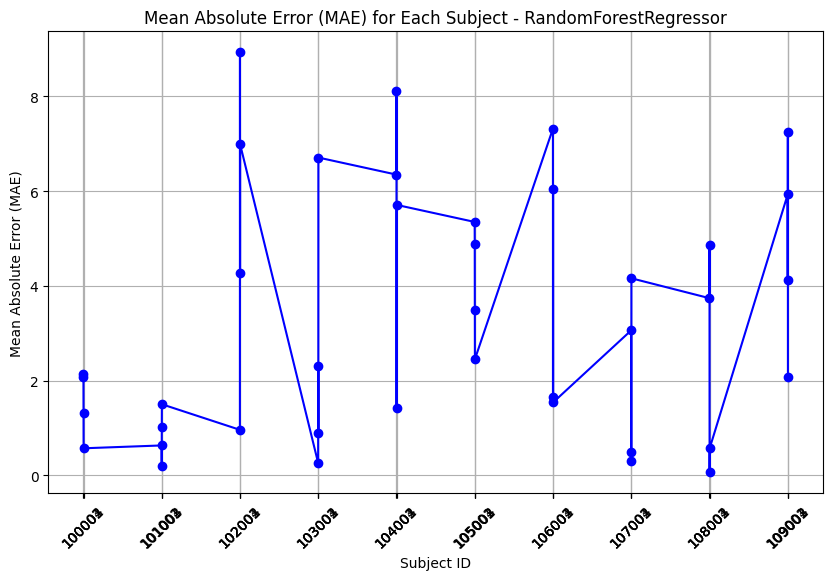

In [64]:
# Extract subject IDs and MAE values for plotting
# Sort mae_values by subject_id to ensure the order matches subject_ids_for_plot
mae_values_sorted = sorted(mae_values, key=lambda x: x[0])

# Now, create the sorted lists for plotting
subject_ids_for_plot = [subject_id for subject_id, mae in mae_values_sorted]
mae_values_for_plot = [mae for subject_id, mae in mae_values_sorted]

# Plot the MAE values against subject IDs
plt.figure(figsize=(10, 6))
plt.plot(subject_ids_for_plot, mae_values_for_plot, marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Error (MAE) for Each Subject - RandomForestRegressor')
plt.xlabel('Subject ID')
plt.ylabel('Mean Absolute Error (MAE)')

# Ensure all x-axis values are plotted
plt.xticks(subject_ids_for_plot, rotation=45)  # Rotate for readability if needed
plt.grid(True)
plt.show()

### SVR model

In [58]:
from sklearn.svm import SVR
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


class SignalProcessor:
    def __init__(self, database_path: str, chunk_size: int = 300):
        self.database_path = database_path
        self.chunk_size = chunk_size

    def detect_peaks_in_signal(self, signal_data: np.ndarray) -> int:
        """
        Detect peaks in the given signal data using continuous wavelet transform.
        """
        peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
        return len(peak_indices)

    def extract_signals_for_subject(self, subject_id: str, signal_type: str = "ECG") -> np.ndarray:
        """
        Extracts the signal data (ECG or PPG) for a given subject.
        """
        file_path = f"{self.database_path}/{subject_id}/{subject_id}_{signal_type}"
        record = wfdb.rdrecord(file_path)
        signal_data = record.p_signal.flatten()
        print(f"Loaded {signal_type} signal for subject {subject_id}. Total samples: {len(signal_data)}")
        return signal_data

    def split_signal_into_chunks(self, signal_data: np.ndarray) -> list:
        """
        Splits the signal data into chunks of specified size.
        """
        chunks = [
            signal_data[i:i + self.chunk_size]
            for i in range(0, len(signal_data), self.chunk_size)
            if len(signal_data[i:i + self.chunk_size]) == self.chunk_size
        ]
        print(f"Split signal into {len(chunks)} chunks of size {self.chunk_size}")
        return chunks

    def train_model_on_subject(self, subject_id: str) -> RandomForestRegressor:
        """
        Train a RandomForestRegressor on ECG data of a subject and return the model.
        """
        print(f"Training model for subject {subject_id}...")
        ecg_signal = self.extract_signals_for_subject(subject_id, signal_type="ECG")
        ecg_chunks = self.split_signal_into_chunks(ecg_signal)

        X_train = []
        y_train = []
        for i, chunk in enumerate(ecg_chunks):
            peak_count = self.detect_peaks_in_signal(chunk)
            X_train.append(chunk)
            y_train.append(peak_count)
            print(f"ECG Chunk {i + 1}: Samples = {len(chunk)}, Peaks = {peak_count}")

        model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
        model.fit(np.array(X_train), np.array(y_train))
        print(f"Model trained for subject {subject_id}.")
        return model

    def test_model_on_subject(self, model: RandomForestRegressor, subject_id: str):
        """
        Test the trained model on PPG data of a subject and compute the MAE.
        """
        print(f"Testing model for subject {subject_id}...")
        ppg_signal = self.extract_signals_for_subject(subject_id, signal_type="PPG")
        ppg_chunks = self.split_signal_into_chunks(ppg_signal)

        predictions = []
        actual_counts = []
        for i, chunk in enumerate(ppg_chunks):
            predicted_peaks = model.predict([chunk])[0]
            actual_peaks = self.detect_peaks_in_signal(chunk)
            predictions.append(predicted_peaks)
            actual_counts.append(actual_peaks)
            print(f"PPG Chunk {i + 1}: Samples = {len(chunk)}, Predicted Peaks = {predicted_peaks:.2f}, Actual Peaks = {actual_peaks}")

        # Calculate MAE
        mae = mean_absolute_error(actual_counts, predictions)
        print(f"Mean Absolute Error (MAE) for subject {subject_id}: {mae:.2f}")
        
        return mae

    def process_subject(self, subject_id: str):
        """
        Process a subject's data by training on ECG and testing on PPG signals.
        """
        try:
            model = self.train_model_on_subject(subject_id)
            mae = self.test_model_on_subject(model, subject_id)
            print(f"Processing complete for subject {subject_id}. MAE = {mae:.2f}")
            return mae
        except Exception as e:
            print(f"Failed to process subject {subject_id}: {e}")


# Example usage
database_path = "./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0"
processor = SignalProcessor(database_path)

# Process all subjects (assuming folder names are signal IDs)
subject_ids = [
    100001, 100002, 100003, 100004, 
    101001, 101002, 101003, 101004, 
    102001, 102002, 102003, 102004, 
    103001, 103002, 103003, 103004, 
    104001, 104002, 104003, 104004, 
    105001, 105002, 105003, 105004, 
    106001, 106002, 106003, 106004, 
    107001, 107002, 107003, 107004, 
    108001, 108002, 108003, 108004, 
    109001, 109002, 109003, 109004
]


# Store MAE for each subject
mae_values = []
for subject_id in subject_ids:
    print(f"Processing subject {subject_id}...")
    mae = processor.process_subject(subject_id)
    mae_values.append((subject_id, mae))





Processing subject 100001...
Training model for subject 100001...
Loaded ECG signal for subject 100001. Total samples: 10000
Split signal into 33 chunks of size 300
ECG Chunk 1: Samples = 300, Peaks = 18
ECG Chunk 2: Samples = 300, Peaks = 16
ECG Chunk 3: Samples = 300, Peaks = 14
ECG Chunk 4: Samples = 300, Peaks = 14
ECG Chunk 5: Samples = 300, Peaks = 13
ECG Chunk 6: Samples = 300, Peaks = 19
ECG Chunk 7: Samples = 300, Peaks = 14
ECG Chunk 8: Samples = 300, Peaks = 18
ECG Chunk 9: Samples = 300, Peaks = 20
ECG Chunk 10: Samples = 300, Peaks = 13
ECG Chunk 11: Samples = 300, Peaks = 15
ECG Chunk 12: Samples = 300, Peaks = 12
ECG Chunk 13: Samples = 300, Peaks = 14
ECG Chunk 14: Samples = 300, Peaks = 11
ECG Chunk 15: Samples = 300, Peaks = 17
ECG Chunk 16: Samples = 300, Peaks = 16
ECG Chunk 17: Samples = 300, Peaks = 16
ECG Chunk 18: Samples = 300, Peaks = 17
ECG Chunk 19: Samples = 300, Peaks = 14
ECG Chunk 20: Samples = 300, Peaks = 17
ECG Chunk 21: Samples = 300, Peaks = 16
ECG 

In [59]:
# Extract only the MAE values from the list of tuples
mae_values_only = [mae for subject_id, mae in mae_values]

# Calculate the average MAE
avg_mae = np.mean(mae_values_only)

print(f"Average MAE across all subjects: {avg_mae:.2f}")

Average MAE across all subjects: 3.14


### Visualizing MAE obtained using the SVR model

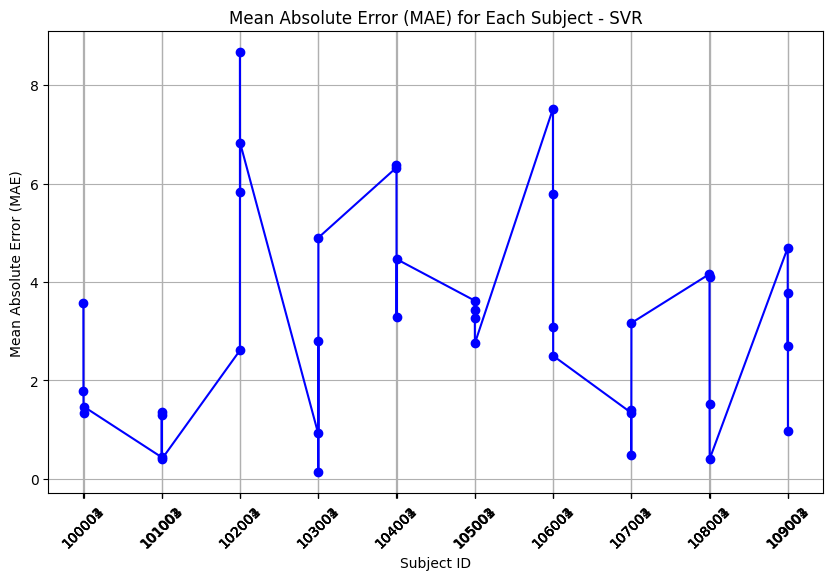

In [42]:
# Extract subject IDs and MAE values for plotting
# Sort mae_values by subject_id to ensure the order matches subject_ids_for_plot
mae_values_sorted = sorted(mae_values, key=lambda x: x[0])

# Now, create the sorted lists for plotting
subject_ids_for_plot = [subject_id for subject_id, mae in mae_values_sorted]
mae_values_for_plot = [mae for subject_id, mae in mae_values_sorted]

# Plot the MAE values against subject IDs
plt.figure(figsize=(10, 6))
plt.plot(subject_ids_for_plot, mae_values_for_plot, marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Error (MAE) for Each Subject - SVR')
plt.xlabel('Subject ID')
plt.ylabel('Mean Absolute Error (MAE)')

# Ensure all x-axis values are plotted
plt.xticks(subject_ids_for_plot, rotation=45)  # Rotate for readability if needed
plt.grid(True)
plt.show()

### SVR with scaled input

In [47]:


from sklearn.svm import SVR
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


class SignalProcessor:
    def __init__(self, database_path: str, chunk_size: int = 300):
        self.database_path = database_path
        self.chunk_size = chunk_size

    def detect_peaks_in_signal(self, signal_data: np.ndarray) -> int:
        """
        Detect peaks in the given signal data using continuous wavelet transform.
        """
        peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
        return len(peak_indices)

    def extract_signals_for_subject(self, subject_id: str, signal_type: str = "ECG") -> np.ndarray:
        """
        Extracts the signal data (ECG or PPG) for a given subject.
        """
        file_path = f"{self.database_path}/{subject_id}/{subject_id}_{signal_type}"
        record = wfdb.rdrecord(file_path)
        signal_data = record.p_signal.flatten()
        print(f"Loaded {signal_type} signal for subject {subject_id}. Total samples: {len(signal_data)}")
        return signal_data

    def split_signal_into_chunks(self, signal_data: np.ndarray) -> list:
        """
        Splits the signal data into chunks of specified size.
        """
        chunks = [
            signal_data[i:i + self.chunk_size]
            for i in range(0, len(signal_data), self.chunk_size)
            if len(signal_data[i:i + self.chunk_size]) == self.chunk_size
        ]
        print(f"Split signal into {len(chunks)} chunks of size {self.chunk_size}")
        return chunks

    def train_model_on_subject(self, subject_id: str) -> RandomForestRegressor:
        """
        Train a RandomForestRegressor on ECG data of a subject and return the model.
        """
        print(f"Training model for subject {subject_id}...")
        ecg_signal = self.extract_signals_for_subject(subject_id, signal_type="ECG")
        ecg_chunks = self.split_signal_into_chunks(ecg_signal)

        X_train = []
        y_train = []
        for i, chunk in enumerate(ecg_chunks):
            peak_count = self.detect_peaks_in_signal(chunk)
            X_train.append(chunk)
            y_train.append(peak_count)
            print(f"ECG Chunk {i + 1}: Samples = {len(chunk)}, Peaks = {peak_count}")
        # Scale the features before fitting SVR model
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(np.array(X_train))
        model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
        model.fit(np.array(X_train_scaled), np.array(y_train))
        print(f"Model trained for subject {subject_id}.")
        return model

    def test_model_on_subject(self, model: RandomForestRegressor, subject_id: str):
        """
        Test the trained model on PPG data of a subject and compute the MAE.
        """
        print(f"Testing model for subject {subject_id}...")
        ppg_signal = self.extract_signals_for_subject(subject_id, signal_type="PPG")
        ppg_chunks = self.split_signal_into_chunks(ppg_signal)

        predictions = []
        actual_counts = []
        for i, chunk in enumerate(ppg_chunks):
            predicted_peaks = model.predict([chunk])[0]
            actual_peaks = self.detect_peaks_in_signal(chunk)
            predictions.append(predicted_peaks)
            actual_counts.append(actual_peaks)
            print(f"PPG Chunk {i + 1}: Samples = {len(chunk)}, Predicted Peaks = {predicted_peaks:.2f}, Actual Peaks = {actual_peaks}")

        # Calculate MAE
        mae = mean_absolute_error(actual_counts, predictions)
        print(f"Mean Absolute Error (MAE) for subject {subject_id}: {mae:.2f}")
        
        return mae

    def process_subject(self, subject_id: str):
        """
        Process a subject's data by training on ECG and testing on PPG signals.
        """
        try:
            model = self.train_model_on_subject(subject_id)
            mae = self.test_model_on_subject(model, subject_id)
            print(f"Processing complete for subject {subject_id}. MAE = {mae:.2f}")
            return mae
        except Exception as e:
            print(f"Failed to process subject {subject_id}: {e}")


# Example usage
database_path = "./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0"
processor = SignalProcessor(database_path)

# Process all subjects (assuming folder names are signal IDs)
subject_ids = [
    100001, 100002, 100003, 100004, 
    101001, 101002, 101003, 101004, 
    102001, 102002, 102003, 102004, 
    103001, 103002, 103003, 103004, 
    104001, 104002, 104003, 104004, 
    105001, 105002, 105003, 105004, 
    106001, 106002, 106003, 106004, 
    107001, 107002, 107003, 107004, 
    108001, 108002, 108003, 108004, 
    109001, 109002, 109003, 109004
]


# Store MAE for each subject
mae_values = []
for subject_id in subject_ids:
    print(f"Processing subject {subject_id}...")
    mae = processor.process_subject(subject_id)
    mae_values.append((subject_id, mae))





Processing subject 100001...
Training model for subject 100001...
Loaded ECG signal for subject 100001. Total samples: 10000
Split signal into 33 chunks of size 300
ECG Chunk 1: Samples = 300, Peaks = 18
ECG Chunk 2: Samples = 300, Peaks = 16
ECG Chunk 3: Samples = 300, Peaks = 14
ECG Chunk 4: Samples = 300, Peaks = 14
ECG Chunk 5: Samples = 300, Peaks = 13
ECG Chunk 6: Samples = 300, Peaks = 19
ECG Chunk 7: Samples = 300, Peaks = 14
ECG Chunk 8: Samples = 300, Peaks = 18
ECG Chunk 9: Samples = 300, Peaks = 20
ECG Chunk 10: Samples = 300, Peaks = 13
ECG Chunk 11: Samples = 300, Peaks = 15
ECG Chunk 12: Samples = 300, Peaks = 12
ECG Chunk 13: Samples = 300, Peaks = 14
ECG Chunk 14: Samples = 300, Peaks = 11
ECG Chunk 15: Samples = 300, Peaks = 17
ECG Chunk 16: Samples = 300, Peaks = 16
ECG Chunk 17: Samples = 300, Peaks = 16
ECG Chunk 18: Samples = 300, Peaks = 17
ECG Chunk 19: Samples = 300, Peaks = 14
ECG Chunk 20: Samples = 300, Peaks = 17
ECG Chunk 21: Samples = 300, Peaks = 16
ECG 

In [56]:
# Extract only the MAE values from the list of tuples
mae_values_only = [mae for subject_id, mae in mae_values]

# Calculate the average MAE
avg_mae = np.mean(mae_values_only)

print(f"Average MAE across all subjects: {avg_mae:.2f}")

Average MAE across all subjects: 3.06


### Visualizing MAE obtained using SVR and scaled inputs

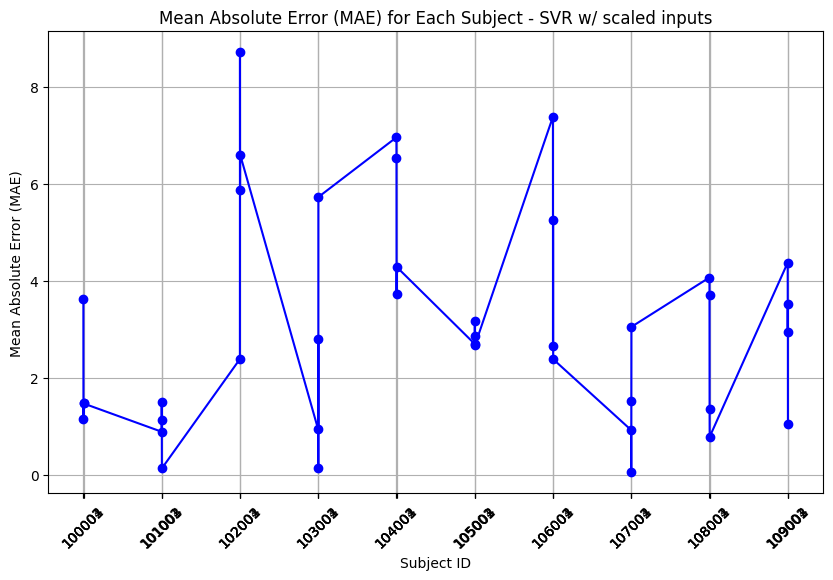

In [52]:
# Extract subject IDs and MAE values for plotting
# Sort mae_values by subject_id to ensure the order matches subject_ids_for_plot
mae_values_sorted = sorted(mae_values, key=lambda x: x[0])

# Now, create the sorted lists for plotting
subject_ids_for_plot = [subject_id for subject_id, mae in mae_values_sorted]
mae_values_for_plot = [mae for subject_id, mae in mae_values_sorted]

# Plot the MAE values against subject IDs
plt.figure(figsize=(10, 6))
plt.plot(subject_ids_for_plot, mae_values_for_plot, marker='o', linestyle='-', color='b')
plt.title('Mean Absolute Error (MAE) for Each Subject - SVR w/ scaled inputs')
plt.xlabel('Subject ID')
plt.ylabel('Mean Absolute Error (MAE)')

# Ensure all x-axis values are plotted
plt.xticks(subject_ids_for_plot, rotation=45)  # Rotate for readability if needed
plt.grid(True)
plt.show()

### Gradiant Boosting

In [69]:
from sklearn.svm import SVR
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


class SignalProcessor:
    def __init__(self, database_path: str, chunk_size: int = 300):
        self.database_path = database_path
        self.chunk_size = chunk_size

    def detect_peaks_in_signal(self, signal_data: np.ndarray) -> int:
        """
        Detect peaks in the given signal data using continuous wavelet transform.
        """
        peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
        return len(peak_indices)

    def extract_signals_for_subject(self, subject_id: str, signal_type: str = "ECG") -> np.ndarray:
        """
        Extracts the signal data (ECG or PPG) for a given subject.
        """
        file_path = f"{self.database_path}/{subject_id}/{subject_id}_{signal_type}"
        record = wfdb.rdrecord(file_path)
        signal_data = record.p_signal.flatten()
        print(f"Loaded {signal_type} signal for subject {subject_id}. Total samples: {len(signal_data)}")
        return signal_data

    def split_signal_into_chunks(self, signal_data: np.ndarray) -> list:
        """
        Splits the signal data into chunks of specified size.
        """
        chunks = [
            signal_data[i:i + self.chunk_size]
            for i in range(0, len(signal_data), self.chunk_size)
            if len(signal_data[i:i + self.chunk_size]) == self.chunk_size
        ]
        print(f"Split signal into {len(chunks)} chunks of size {self.chunk_size}")
        return chunks

    def train_model_on_subject(self, subject_id: str, model: object = RandomForestRegressor()) -> object:
        """
        Train a model on ECG data of a subject and return the trained model.
        """
        print(f"Training model for subject {subject_id}...")
        ecg_signal = self.extract_signals_for_subject(subject_id, signal_type="ECG")
        ecg_chunks = self.split_signal_into_chunks(ecg_signal)

        X_train = []
        y_train = []
        for i, chunk in enumerate(ecg_chunks):
            peak_count = self.detect_peaks_in_signal(chunk)
            X_train.append(chunk)
            y_train.append(peak_count)
            print(f"ECG Chunk {i + 1}: Samples = {len(chunk)}, Peaks = {peak_count}")

        model.fit(np.array(X_train), np.array(y_train))
        print(f"Model trained for subject {subject_id}.")
        return model

    def test_model_on_subject(self, model: object, subject_id: str):
        """
        Test the trained model on PPG data of a subject and compute the MAE.
        """
        print(f"Testing model for subject {subject_id}...")
        ppg_signal = self.extract_signals_for_subject(subject_id, signal_type="PPG")
        ppg_chunks = self.split_signal_into_chunks(ppg_signal)

        predictions = []
        actual_counts = []
        for i, chunk in enumerate(ppg_chunks):
            predicted_peaks = model.predict([chunk])[0]
            actual_peaks = self.detect_peaks_in_signal(chunk)
            predictions.append(predicted_peaks)
            actual_counts.append(actual_peaks)
            print(f"PPG Chunk {i + 1}: Samples = {len(chunk)}, Predicted Peaks = {predicted_peaks:.2f}, Actual Peaks = {actual_peaks}")

        # Calculate MAE
        mae = mean_absolute_error(actual_counts, predictions)
        print(f"Mean Absolute Error (MAE) for subject {subject_id}: {mae:.2f}")
        
        return mae

    def process_subject(self, subject_id: str, model: object = RandomForestRegressor()):
        """
        Process a subject's data by training on ECG and testing on PPG signals using a specified model.
        """
        try:
            model = self.train_model_on_subject(subject_id, model)
            mae = self.test_model_on_subject(model, subject_id)
            print(f"Processing complete for subject {subject_id}. MAE = {mae:.2f}")
            return mae
        except Exception as e:
            print(f"Failed to process subject {subject_id}: {e}")


# Example usage
database_path = "./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0"
processor = SignalProcessor(database_path)

# Process all subjects (assuming folder names are signal IDs)
subject_ids = [
    100001, 100002, 100003, 100004, 
    101001, 101002, 101003, 101004, 
    102001, 102002, 102003, 102004, 
    103001, 103002, 103003, 103004, 
    104001, 104002, 104003, 104004, 
    105001, 105002, 105003, 105004, 
    106001, 106002, 106003, 106004, 
    107001, 107002, 107003, 107004, 
    108001, 108002, 108003, 108004, 
    109001, 109002, 109003, 109004
]




In [71]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Store MAE for each subject
mae_values = []
for subject_id in subject_ids:
    #print(f"Processing subject {subject_id}...")
    mae = processor.process_subject(subject_id, model)  # Example using SVR
    mae_values.append((subject_id, mae))

# Extract only the MAE values from the list of tuples
mae_values_only = [mae for subject_id, mae in mae_values]

# Calculate the average MAE
avg_mae = np.mean(mae_values_only)

print(f"Average MAE across all subjects for model {model.__class__.__name__}: {avg_mae:.2f}")


Processing subject 100001...
Training model for subject 100001...
Loaded ECG signal for subject 100001. Total samples: 10000
Split signal into 33 chunks of size 300
ECG Chunk 1: Samples = 300, Peaks = 18
ECG Chunk 2: Samples = 300, Peaks = 16
ECG Chunk 3: Samples = 300, Peaks = 14
ECG Chunk 4: Samples = 300, Peaks = 14
ECG Chunk 5: Samples = 300, Peaks = 13
ECG Chunk 6: Samples = 300, Peaks = 19
ECG Chunk 7: Samples = 300, Peaks = 14
ECG Chunk 8: Samples = 300, Peaks = 18
ECG Chunk 9: Samples = 300, Peaks = 20
ECG Chunk 10: Samples = 300, Peaks = 13
ECG Chunk 11: Samples = 300, Peaks = 15
ECG Chunk 12: Samples = 300, Peaks = 12
ECG Chunk 13: Samples = 300, Peaks = 14
ECG Chunk 14: Samples = 300, Peaks = 11
ECG Chunk 15: Samples = 300, Peaks = 17
ECG Chunk 16: Samples = 300, Peaks = 16
ECG Chunk 17: Samples = 300, Peaks = 16
ECG Chunk 18: Samples = 300, Peaks = 17
ECG Chunk 19: Samples = 300, Peaks = 14
ECG Chunk 20: Samples = 300, Peaks = 17
ECG Chunk 21: Samples = 300, Peaks = 16
ECG 

### Testing MAE across several model types!

In [74]:
from sklearn.svm import SVR
import wfdb
import numpy as np
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


class SignalProcessor:
    def __init__(self, database_path: str, chunk_size: int = 300):
        self.database_path = database_path
        self.chunk_size = chunk_size

    def detect_peaks_in_signal(self, signal_data: np.ndarray, verbose: bool = False) -> int:
        """
        Detect peaks in the given signal data using continuous wavelet transform.
        """
        peak_indices = signal.find_peaks_cwt(signal_data, np.arange(1, 10))
        if verbose:
            print(f"Detected {len(peak_indices)} peaks.")
        return len(peak_indices)

    def extract_signals_for_subject(self, subject_id: str, signal_type: str = "ECG", verbose: bool = False) -> np.ndarray:
        """
        Extracts the signal data (ECG or PPG) for a given subject.
        """
        file_path = f"{self.database_path}/{subject_id}/{subject_id}_{signal_type}"
        record = wfdb.rdrecord(file_path)
        signal_data = record.p_signal.flatten()
        if verbose:
            print(f"Loaded {signal_type} signal for subject {subject_id}. Total samples: {len(signal_data)}")
        return signal_data

    def split_signal_into_chunks(self, signal_data: np.ndarray, verbose: bool = False) -> list:
        """
        Splits the signal data into chunks of specified size.
        """
        chunks = [
            signal_data[i:i + self.chunk_size]
            for i in range(0, len(signal_data), self.chunk_size)
            if len(signal_data[i:i + self.chunk_size]) == self.chunk_size
        ]
        if verbose:
            print(f"Split signal into {len(chunks)} chunks of size {self.chunk_size}")
        return chunks

    def train_model_on_subject(self, subject_id: str, model: object = RandomForestRegressor(), verbose: bool = False) -> object:
        """
        Train a model on ECG data of a subject and return the trained model.
        """
        if verbose:
            print(f"Training model for subject {subject_id}...")
        ecg_signal = self.extract_signals_for_subject(subject_id, signal_type="ECG", verbose=verbose)
        ecg_chunks = self.split_signal_into_chunks(ecg_signal, verbose=verbose)

        X_train = []
        y_train = []
        for i, chunk in enumerate(ecg_chunks):
            peak_count = self.detect_peaks_in_signal(chunk, verbose=verbose)
            X_train.append(chunk)
            y_train.append(peak_count)
            if verbose:
                print(f"ECG Chunk {i + 1}: Samples = {len(chunk)}, Peaks = {peak_count}")

        model.fit(np.array(X_train), np.array(y_train))
        if verbose:
            print(f"Model trained for subject {subject_id}.")
        return model

    def test_model_on_subject(self, model: object, subject_id: str, verbose: bool = False):
        """
        Test the trained model on PPG data of a subject and compute the MAE.
        """
        if verbose:
            print(f"Testing model for subject {subject_id}...")
        ppg_signal = self.extract_signals_for_subject(subject_id, signal_type="PPG", verbose=verbose)
        ppg_chunks = self.split_signal_into_chunks(ppg_signal, verbose=verbose)

        predictions = []
        actual_counts = []
        for i, chunk in enumerate(ppg_chunks):
            predicted_peaks = model.predict([chunk])[0]
            actual_peaks = self.detect_peaks_in_signal(chunk, verbose=verbose)
            predictions.append(predicted_peaks)
            actual_counts.append(actual_peaks)
            if verbose:
                print(f"PPG Chunk {i + 1}: Samples = {len(chunk)}, Predicted Peaks = {predicted_peaks:.2f}, Actual Peaks = {actual_peaks}")

        # Calculate MAE
        mae = mean_absolute_error(actual_counts, predictions)
        if verbose:
            print(f"Mean Absolute Error (MAE) for subject {subject_id}: {mae:.2f}")
        
        return mae

    def process_subject(self, subject_id: str, model: object = RandomForestRegressor(), verbose: bool = False):
        """
        Process a subject's data by training on ECG and testing on PPG signals using a specified model.
        """
        try:
            model = self.train_model_on_subject(subject_id, model, verbose=verbose)
            mae = self.test_model_on_subject(model, subject_id, verbose=verbose)
            if verbose:
                print(f"Processing complete for subject {subject_id}. MAE = {mae:.2f}")
            return mae
        except Exception as e:
            if verbose:
                print(f"Failed to process subject {subject_id}: {e}")
            return None


# Example usage
database_path = "./brno-university-of-technology-smartphone-ppg-database-but-ppg-2.0.0"
processor = SignalProcessor(database_path)

# Process all subjects (assuming folder names are signal IDs)
subject_ids = [
    100001, 100002, 100003, 100004, 
    101001, 101002, 101003, 101004, 
    102001, 102002, 102003, 102004, 
    103001, 103002, 103003, 103004, 
    104001, 104002, 104003, 104004, 
    105001, 105002, 105003, 105004, 
    106001, 106002, 106003, 106004, 
    107001, 107002, 107003, 107004, 
    108001, 108002, 108003, 108004, 
    109001, 109002, 109003, 109004
]



In [80]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import ExtraTreesRegressor

# List of models
models = [
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    LinearRegression(),
    SVR(kernel='rbf'),
    DecisionTreeRegressor(random_state=42),
    KNeighborsRegressor(n_neighbors=5),
    AdaBoostRegressor(n_estimators=50, random_state=42),
    Ridge(alpha=1.0),
    GaussianProcessRegressor(),
    ExtraTreesRegressor(n_estimators=100, random_state=42)
]

# Example of how to use the models list
for model in models:
    print(f"Training and testing using model: {model.__class__.__name__}")
    # Train and test with each model (assuming the rest of your code handles training and testing)
    # processor.process_subject(subject_id, model=model, verbose=True)
    # Store MAE for each subject
    mae_values = []
    for subject_id in subject_ids:
        #print(f"Processing subject {subject_id}...")
        mae = processor.process_subject(subject_id, model, verbose=False)  # Example using SVR
        mae_values.append((subject_id, mae))
    
    # Extract only the MAE values from the list of tuples
    mae_values_only = [mae for subject_id, mae in mae_values]
    
    # Calculate the average MAE
    avg_mae = np.mean(mae_values_only)
    
    print(f"Average MAE across all signals for model {model.__class__.__name__}: {avg_mae:.2f}")

Training and testing using model: RandomForestRegressor
Average MAE across all signals for model RandomForestRegressor: 3.29
Training and testing using model: GradientBoostingRegressor
Average MAE across all signals for model GradientBoostingRegressor: 3.56
Training and testing using model: LinearRegression
Average MAE across all signals for model LinearRegression: 3.60
Training and testing using model: SVR
Average MAE across all signals for model SVR: 3.14
Training and testing using model: DecisionTreeRegressor
Average MAE across all signals for model DecisionTreeRegressor: 3.75
Training and testing using model: KNeighborsRegressor
Average MAE across all signals for model KNeighborsRegressor: 3.18
Training and testing using model: AdaBoostRegressor
Average MAE across all signals for model AdaBoostRegressor: 3.18
Training and testing using model: Ridge
Average MAE across all signals for model Ridge: 3.60
Training and testing using model: GaussianProcessRegressor
Average MAE across all 